In [2]:
%matplotlib inline
import numpy as np
from spectral_cube import SpectralCube
from astropy import units as u
from matplotlib import pyplot as plt
import warnings 
from astropy.coordinates import SkyCoord
from astroquery.splatalogue import Splatalogue
import aplpy
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from astropy.io import fits
from scipy.signal import find_peaks

warnings.filterwarnings('ignore') # turns of annoying red warning boxes


In [3]:
B228cont = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/B228_jesdd5.fits'
B228contd1cless = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/b228jesd1c_less.fits'
B228cont039 = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/b228jes039.fits'
#B228cont2 = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/B228autocont.fits'

In [61]:
#WCS COORDINATES OF b228 RA: 235.75958333333332, DEC:-34.15208333333333

def Read_Cube(file_name):
    cube = (SpectralCube.read(file_name))
    cube.spectral_axis
    cube2 = cube.with_spectral_unit(u.km/u.s , velocity_convention = 'radio', rest_value = cube.header['RESTFRQ'] *u.Hz)
    cube2.spectral_axis
    return cube2

def Draw_Box(cube):
    if cube.header['NAXIS3'] == 1 :
        boxsize=40
        drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
        drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
        cutcube = cube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1])
        return cutcube
    
    elif cube.header['NAXIS3'] > 1 :
        boxsize=80 
        drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
        drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
        cutcube = cube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1],zlo=0,zhi=300)
        spectrum = cutcube.sum(axis=(1,2)).quicklook()
        return cutcube
    
    else:
        print("ERROR")
        
def RMS(cube):
    if cube.header['NAXIS3'] == 1 :
        bluerms = 0 
        redrms = 0
        casa_rms = 0.0007 *u.Jy 
        return casa_rms,bluerms,redrms
    
    elif cube.header['NAXIS3'] > 1 :
        rmschans1 = range(0,52) #channels that are emission free
        bluechannels = range(229,338) #channels blue shifted 
        redchannels = range(115,215) #channels red shifted
        
        emission_free_cube = cube[0:52,:,:] # create a new cube from emission free channels
        em_free_mom0 = emission_free_cube.moment(order=0) # create moment 0 map for emission free cube
        rms = np.nanstd(em_free_mom0.value)
        
        # create a scaling factor from the moment map 
        bluescale = em_free_mom0/(np.sqrt((len(rmschans1)/len(bluechannels))))
        redscale = em_free_mom0/(np.sqrt((len(rmschans1)/len(redchannels))))
        
        #calculate the red and blue shfited RMS
        bluerms = np.nanstd(bluescale.value) #rms of the blue scaled moment map
        redrms = np.nanstd(redscale.value) #rms of the red scaled moment map
        
        print('The r,r and b rms are:',rms,redrms,bluerms)
        return rms,bluerms,redrms
        
    else:
        print("ERROR")
        
def Moment_Maps(cube,cutcube):
    cube.allow_huge_operations=True
    linecube = cube.spectral_slab(-4* u.km / u.s, 14 * u.km / u.s) # defines the "line region" as 0 to 20 km /s
    #moment0 = linecube.moment(order=0) # shows amount of gas at each pixel (column density)
    boxsize=80 
    drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
    drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
    cubee = linecube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1],zlo=0,zhi=375)
    moment0 = cubee.moment(order=0)
    
    # look at whole outflow
#     red_high = 15
#     red_low = 5.8
#     blue_low = -4
#     blue_high = 5
    
#     #delta 2 and delta 4
#     red_high = 9.8
#     red_low = 5.8
#     blue_low = 1
#     blue_high = 5
    
    
#     #delta 6
#     red_high = 11.8
#     red_low = 9.8
#     blue_low = -1
#     blue_high = 1
    
#     #delta 8
    red_high = 13.8
    red_low = 11.8
    blue_low = -1
    blue_high = -4
 
    bluecube = cutcube.spectral_slab(blue_low*u.km/u.s, blue_high*u.km/u.s) #define new cube by frequency
    redcube = cutcube.spectral_slab(red_low*u.km/u.s, red_high*u.km/u.s) #define new cube by frequency
    
    bluemom = bluecube.moment(order=0)
    redmom = redcube.moment(order=0)
    
    return moment0,bluemom,redmom
    

def Contours(cube,cutcube,rms,bluerms,redrms,bluemom,redmom,mom0):
    if cube.header['NAXIS3'] == 1 :
        fig = aplpy.FITSFigure(cutcube[0,:,:].hdu, dimensions=[0, 1])
        fig.add_beam(major=cube.header['bmaj'],minor=cube.header['bmin'],angle=cube.header['bpa'],fill=True)
        fig.axis_labels.show()
        fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
        fig.axis_labels.set_ytext("Declination (ICRS)") 
        plt.imshow(cutcube[0,:,:].hdu.data, cmap = 'inferno') 
         
        cbar = plt.colorbar(spacing = 'proportional',shrink=0.9)
        cbar.ax.set_ylabel('Moment 0 Map Intensity')

        levs_rms = np.arange(0,1000)*rms.value
        
        print("1sigma is",rms.value*1000)
        
    
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[3:4],colors='white',linestyles= 'dashed')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[5:6], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[10:11], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[15:16], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[20:21], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[30:31], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[50:51], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[100:50], colors='white')
        #fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[100:50], colors='white')
        
        fig.savefig('B228_463ghz.pdf')
        
    elif cube.header['NAXIS3'] > 1:
     
        fig = aplpy.FITSFigure(mom0.hdu, dimensions=[1, 0])
        fig.axis_labels.show()
        fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
        fig.axis_labels.set_ytext("Declination (ICRS)") 

        plt.imshow(mom0.hdu.data, cmap='inferno') 

        # set up contours by RMS
        levsblu = np.arange(0,1000)*bluerms
        levsred = np.arange(0,1000)*redrms
        
        fig.show_contour(bluemom.hdu , levels = levsblu[5::6], colors='blue', convention= 'radio', dimensions=[1, 0], slices=[])
        fig.show_contour(redmom.hdu , levels = levsred[5::6], colors='red', convention= 'radio', dimensions=[1, 0], slices=[])
        fig.show_contour(bluemom.hdu , levels = levsblu[10::11], colors='blue', convention= 'radio', dimensions=[1, 0], slices=[])
        fig.show_contour(redmom.hdu , levels = levsred[10::11], colors='red', convention= 'radio', dimensions=[1, 0], slices=[])
        fig.show_contour(bluemom.hdu , levels = levsblu[15::16], colors='blue', convention= 'radio', dimensions=[1, 0], slices=[])
        fig.show_contour(redmom.hdu , levels = levsred[15::16], colors='red', convention= 'radio', dimensions=[1, 0], slices=[])
         
    else:
        print("error!")

def Main(file_name):
    
    cube = Read_Cube(file_name)
    if cube.header['NAXIS3'] == 1:
        cutcube = Draw_Box(cube)
        rms,bluerms,redrms = RMS(cube)
        mom0=0
        bluemom = 0
        redmom = 0
        Contours(cube,cutcube,rms,bluerms,redrms,bluemom,redmom,mom0)
    elif cube.header['NAXIS3'] > 1:
        cutcube = Draw_Box(cube)
        rms,bluerms,redrms = RMS(cube)
        mom0,bluemom,redmom = Moment_Maps(cube,cutcube)
        Contours(cube,cutcube,rms,bluerms,redrms,bluemom,redmom,mom0)

1sigma is 0.7


INFO: Auto-setting resolution to 12.9032 dpi [aplpy.core]


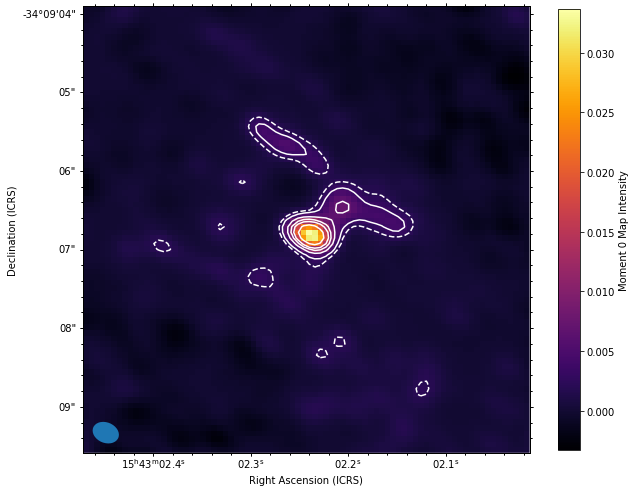

In [62]:
Main(B228cont)

In [60]:
#Main(B228contd1cless)

In [49]:
#Main(B228cont039)